In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'),transforms.RandomHorizontalFlip(),transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose([transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform1)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
batch_size = 200
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


In [4]:
len(trainloader)

250

In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
labels.shape

torch.Size([200])

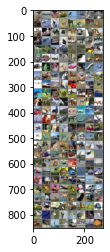

 bird  ship   cat  frog  bird plane   cat  deer   cat plane plane  deer   dog   cat  frog  deer horse truck   cat  ship horse  bird  bird  bird horse  ship  ship   cat horse horse   dog   car horse  frog  ship truck  bird  deer   car   dog truck  frog plane   dog  bird plane truck  deer   car  frog   dog  bird   car   cat plane plane plane  bird truck   dog horse   dog  deer horse plane truck plane truck   car horse truck  deer horse  deer  frog  frog plane horse   dog   cat   dog  frog horse   cat horse horse   dog  deer   car  bird horse  deer  bird plane plane   car  ship truck   cat   car horse plane  bird  deer plane  deer   cat  deer   cat  deer   car   car plane plane plane plane  deer   car plane   cat horse   car   dog  deer   dog   car  deer plane   cat   car truck horse truck  ship   cat  ship  deer  bird horse  deer  deer  deer  ship plane  ship  ship  deer   cat   car  bird   car  ship   cat  frog  deer horse   car plane  ship   car  deer  frog   cat plane   dog   dog   ca

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)
        

        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        
        self.dropout = nn.Dropout(p=.50)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))


        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x=self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [9]:
lossTracker = []
 
for epoch in range(20):
    running_loss = 0.0
    running_loss_track=0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)  
      loss.backward()
      optimizer.step()

      #print statistics
      running_loss += loss.item()

    
      if i % 50 == 49: # print every 50 mini-batches
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
        running_loss_track+=running_loss/50
        running_loss = 0.0
    
    # calculate average losses
    running_loss_track=running_loss_track/5
    print(running_loss_track)
    lossTracker.append(running_loss_track)
    
print("Training Finished.")
  


[1,    50] loss: 1.882
[1,   100] loss: 1.565
[1,   150] loss: 1.419
[1,   200] loss: 1.344
[1,   250] loss: 1.265
1.4950588421821593
[2,    50] loss: 1.178
[2,   100] loss: 1.160
[2,   150] loss: 1.106
[2,   200] loss: 1.089
[2,   250] loss: 1.075
1.1215285024642945
[3,    50] loss: 1.005
[3,   100] loss: 1.008
[3,   150] loss: 0.964
[3,   200] loss: 0.954
[3,   250] loss: 0.951
0.9764106290340424
[4,    50] loss: 0.897
[4,   100] loss: 0.903
[4,   150] loss: 0.892
[4,   200] loss: 0.888
[4,   250] loss: 0.863
0.888438658952713
[5,    50] loss: 0.840
[5,   100] loss: 0.833
[5,   150] loss: 0.815
[5,   200] loss: 0.814
[5,   250] loss: 0.785
0.8173940713405609
[6,    50] loss: 0.788
[6,   100] loss: 0.774
[6,   150] loss: 0.768
[6,   200] loss: 0.773
[6,   250] loss: 0.752
0.7709658484458923
[7,    50] loss: 0.732
[7,   100] loss: 0.732
[7,   150] loss: 0.731
[7,   200] loss: 0.726
[7,   250] loss: 0.711
0.7262171192169189
[8,    50] loss: 0.702
[8,   100] loss: 0.706
[8,   150] loss: 

In [10]:
len(trainloader)

250

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

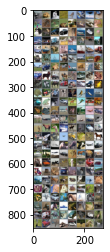

GroundTruth:  plane  frog   dog  deer  bird plane plane   cat   dog  frog  deer  frog truck  ship   car  bird   dog  frog   car   car   cat  ship  ship  deer  ship   car truck horse  deer  frog   cat   dog truck  ship   dog   cat  ship  ship  ship truck truck  deer  ship horse  ship plane   car horse plane   car  frog horse plane  frog plane  frog   car   dog   car horse   cat  ship   cat  frog   cat   dog horse   car truck   car   car  frog  frog truck   car   dog  deer  bird plane  ship   car  frog   cat   car horse plane   cat   car  frog   cat  bird plane   dog  bird plane   car horse  ship horse   dog  deer  ship   car   car  bird horse  bird  ship horse  deer   car truck  deer  ship   cat plane truck  frog  frog horse truck  deer  ship horse  deer   dog plane truck  ship  deer plane   car  frog horse  frog truck   cat   car plane  bird  bird horse   car  ship truck truck  frog   car   cat   dog truck plane plane   car   dog  deer  frog   dog plane   cat   cat   cat   cat   dog   

In [12]:
dataiter = iter(testloader)

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  plane  frog   dog  deer  bird


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 83 %


In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 86.2 %
Accuracy for class car   is: 91.7 %
Accuracy for class bird  is: 73.5 %
Accuracy for class cat   is: 65.7 %
Accuracy for class deer  is: 82.1 %
Accuracy for class dog   is: 75.1 %
Accuracy for class frog  is: 87.2 %
Accuracy for class horse is: 90.8 %
Accuracy for class ship  is: 90.3 %
Accuracy for class truck is: 93.0 %


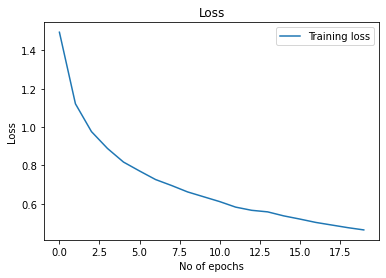

In [18]:
plt.plot(np.arange(0, 20), lossTracker, label='Training loss')
plt.title('Loss')
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()